In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from numpy.ma.core import count
from prompt_toolkit.key_binding.bindings.named_commands import yank_pop

warnings.filterwarnings('ignore')

In [34]:
bd = pd.read_csv('final.csv')
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
bd['age'] = bd['age'].str.replace(',', '.').astype(float)
bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
bd['flag'] = bd['flag'].astype(int)

days_of_week = bd['finish_dttm'].dt.day_name()
days_of_week_num = bd['finish_dttm'].dt.weekday
bd['day_of_week'] = days_of_week
bd['num_of_week'] = days_of_week_num

def vibrosi(bd, i, x):
    return pd.concat([bd[bd[i] < x], bd[bd[i].isna()]])
def vibrosiVniz(bd, i, x):
    return pd.concat([bd[bd[i] > x], bd[bd[i].isna()]])
def percentsByRegion(bd, i):
    df = bd.copy()
    pt = df[df['region_size'] == i][df['age'] >= 18][df['age'] < 60][['age', 'flag']].pivot_table(index='age', columns='product_cd', values='flag', aggfunc=['sum', 'count'])
    # pt['percent'] = pt[(  'sum', 'flag')] / pt[('count', 'flag')] * 100
    # pt[pt['percent'] != 0]

bd['child_flg'] = bd['child_amt'] != 0
bd['child_flg'] = bd['child_flg'].astype(int)

bd = vibrosi(bd, 'confirmed_income', 10000000)
bd = vibrosi(bd, 'predicted_income', 10000000)
bd = vibrosiVniz(bd, 'predicted_income', 0)
bd = vibrosiVniz(bd, 'age', 17)
# хочу делить по: age, auto_flg, partnership_flg, child_flg, realty_type, functional_cd, emp_work_months_cnt, emp_gender_cd, emp_age

df = bd.drop(bd[bd['wo_hit_status_reason_desc'].isin(['Отказ прослушать предложение', 'Не звонить', 'Левый контакт', 'Отказ от диалога', 'отказ от диалога', 'Отказ от разговора', 'Не звонить, резкий негатив', 'Негатив/Не звонить', 'Отказ без объяснения причин', 'просит не звонить', 'Не звонить / резкий негатив', 'Вежливо попросил не звонить', 'Номер не принадлежит страхователю', 'отказ без объяснения причин', 'Отказался озвучить причину', 'Чёрный список', 'негатив к Тинькофф', 'Грубо попросил не звонить', 'Не звонить (негатив)', 'Отказался от диалога', 'Просит больше не звонить', 'Недозвон', 'некорректная заявка', 'Техническая ошибка', 'Не нравится Т-Банк', 'Негатив к Т-Банку', 'Негативная информация о клиенте', 'Отказ без объяснения причины', 'Неизвестен / Не контактирует', 'Человек не участвовал в Дано', 'отменили'])].index)

df['income'] = df['confirmed_income'].fillna(df['predicted_income'])
df['segment_number'] = df['segment_cd'].str.extract(r'\((\d+)\)').astype(float)
df['num_segment'] = (df['segment_cd'].str[2:4])
df['num_segment'] = df['num_segment'].astype(float)

# Функция для определения сезона по номеру месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'

# Преобразуем finish_dttm в datetime, если нужно
df['finish_dttm'] = pd.to_datetime(df['finish_dttm'])

# Извлекаем номер месяца
df['month'] = df['finish_dttm'].dt.month
df['hours'] = df['finish_dttm'].dt.hour

df = vibrosi(df, 'hours', 21)
df = vibrosiVniz(df, 'hours', 6)

# Применяем функцию для создания нового столбца season
df['season'] = df['month'].apply(get_season)


In [35]:
emp = df[['employee_id', 'emp_age', 'emp_age_new', 'emp_gender_cd', 'emp_children_cnt', 'emp_work_months_cnt', 'state_talk_time_sec', 'flag']].groupby(by=['employee_id', 'emp_gender_cd']).mean()
emp.reset_index(inplace=True)
emp['time_uspeh'] = 0

def ok(id):
    return df[df['flag'] == 1][df['employee_id'] == id]['state_talk_time_sec'].mean()

emp['time_uspeh'] = emp['employee_id'].apply(ok)

def min(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 25)

def max(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 75)

emp['min_age'] = emp['employee_id'].apply(min)
emp['max_age'] = emp['employee_id'].apply(max)

# 1. Считаем успешность по employee_id и gender_cd
success_rates = (
    df.groupby(['employee_id', 'gender_cd'])['flag']
    .mean()
    .reset_index()
    .rename(columns={'flag': 'success_rate'})
)

# 2. Для каждого employee_id выбираем gender_cd с максимальной успешностью
best_gender_per_employee = (
    success_rates.loc[success_rates.groupby('employee_id')['success_rate'].idxmax()]
    [['employee_id', 'gender_cd']]
    .rename(columns={'gender_cd': 'lovely_gender_cd'})
)

emp = emp.merge(best_gender_per_employee, on='employee_id', how='left')

# Рассчитываем процент успешности по каждому оператору и продукту
success_rate = df[['employee_id', 'product_cd', 'flag']].groupby(['employee_id', 'product_cd'])['flag'].mean().reset_index()
success_rate.rename(columns={'flag': 'success_rate'}, inplace=True)

# Для каждого оператора выбираем продукт с наибольшим процентом успешности
best_product = success_rate.loc[success_rate.groupby('employee_id')['success_rate'].idxmax()]

# Добавляем столбец best_product в исходный DataFrame
emp = emp.merge(best_product[['employee_id', 'product_cd']], on='employee_id', how='left')
emp.rename(columns={'product_cd': 'best_product'}, inplace=True)

emp = emp.rename({'flag' : 'emp_mean_flag'}, axis=1)

df_plus_emp = df.merge(emp[['employee_id', 'emp_mean_flag', 'time_uspeh', 'min_age', 'max_age', 'lovely_gender_cd', 'best_product']], on='employee_id', how='left')
df_plus_emp['emps_product'] = (df_plus_emp['product_cd'] == df_plus_emp['best_product']).astype(int)

df_plus_emp['female_matching'] = ((df_plus_emp['gender_cd'] == 'F') & (df_plus_emp['emp_gender_cd'] == 'W')).astype(int)
df_plus_emp['male_matching'] = ((df_plus_emp['gender_cd'] == 'M') & (df_plus_emp['emp_gender_cd'] == 'M')).astype(int)
df_plus_emp['gender_matching'] = ((df_plus_emp['female_matching'] == 1) | (df_plus_emp['male_matching'] == 1)).astype(int)
df_plus_emp['age_matching'] = ((df_plus_emp['age'] - df_plus_emp['emp_age']).abs() <= 5).astype(int)

df_plus_emp['lovely_gender_cd_encoded'] = (df_plus_emp['lovely_gender_cd'] == 'M').astype(int)

df_plus_emp['emps_lovely_age'] = ((df_plus_emp['min_age'] < df_plus_emp['age']) & (df_plus_emp['age'] < df_plus_emp['max_age'])).astype(int)

df_plus_emp['child_by_emp_and_cd_flg'] = ((df_plus_emp['child_amt'] > 0) * (df_plus_emp['emp_children_cnt'] > 0)).astype(int)

def sha_budet_rok(x):
    if x <= 22:
        return '18-22'
    elif x <= 40:
        return '23-40'
    elif x <= 60:
        return '41-60'
    elif x <= 80:
        return '61-80'
    else:
        return '80-100'

def liza_prosto_zaputalas_v_oboznacheniyah(x):
    if x == 1:
        return 'Гендеры совпадают'
    if x == 0:
        return 'Гендеры разные'

df_plus_emp['age_groups_cd'] = df_plus_emp['age'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_groups_emp'] = df_plus_emp['emp_age_new'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_group_matching'] = (df_plus_emp['age_groups_cd'] == df_plus_emp['age_groups_emp']).astype(int)
df_plus_emp['pol_sovpadenie'] = df_plus_emp['gender_matching'].apply(lambda x: liza_prosto_zaputalas_v_oboznacheniyah(x))

In [36]:
# Функция для получения нижней границы группы
def extract_min_age(group):
    return int(group.split('-')[0])

# Преобразуем группы в числовые значения (нижняя граница)
df_plus_emp['emp_group_min'] = df_plus_emp['age_groups_emp'].apply(extract_min_age)
df_plus_emp['client_group_min'] = df_plus_emp['age_groups_cd'].apply(extract_min_age)

df_plus_emp['matching_variance'] = np.where(df_plus_emp['emp_group_min'] > df_plus_emp['client_group_min'], 'Оператор старше клиента',
                                   np.where(df_plus_emp['emp_group_min'] == df_plus_emp['client_group_min'], 'Одинаковый возраст', 'Клиент старше операторa'))

# Удаляем временные столбцы, если они не нужны
df_plus_emp.drop(['emp_group_min', 'client_group_min'], axis=1, inplace=True)

In [32]:
i = ['Credit Cards']
now = df_plus_emp[df_plus_emp['product_cd'].isin(i)]
now.shape[0]

7206

In [5]:
bd = pd.read_csv('final.csv')
# 28,5% - от Оператор старше клиента по датаcету
# 29,5% - от женщин по датаcету

In [21]:
import statsmodels.api as sm

cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()

# Создание индикаторов (dummy-переменных) для matching_variance и emp_gender_cd
cc['matching_variance_dummy'] = (cc['matching_variance'] == 'Оператор старше клиента').astype(int)
cc['emp_gender_cd_dummy'] = (cc['emp_gender_cd'] == 'W').astype(int)

# Создание взаимодействия между переменными
cc['interaction'] = cc['matching_variance_dummy'] * 2 + cc['emp_gender_cd_dummy']

# Модель логистической регрессии
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=cc['flag'], groups=cc['interaction'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0326 0.0017  0.0094 0.0559   True
     0      2   0.0618  0.011  0.0103 0.1133   True
     0      3   0.0731    0.0   0.046 0.1001   True
     1      2   0.0291 0.4318 -0.0205 0.0788  False
     1      3   0.0404 0.0001  0.0171 0.0637   True
     2      3   0.0113 0.9433 -0.0402 0.0628  False
---------------------------------------------------


In [9]:
bd = pd.read_csv('final.csv')
bd['income'] = bd['confirmed_income'].fillna(bd['predicted_income'])
bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
bd['flag'] = bd['flag'].astype(int)
bd[['income', 'flag']]

,income,flag
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
18686,NaN,0
18687,NaN,0
18688,NaN,0
18689,9128.5,0


In [38]:
df_plus_emp['product_cd'].value_counts()

product_cd
Credit Cards          7206
Cash Loan             2299
MVNO                  1535
Debit Cards           1366
Investment             541
Secured Loan           418
Casco                  292
Mortgage Insurance     243
Car Loan               227
Osago                   24
Deposit                  8
Travel Avia              5
T-Auto                   2
Name: count, dtype: int64

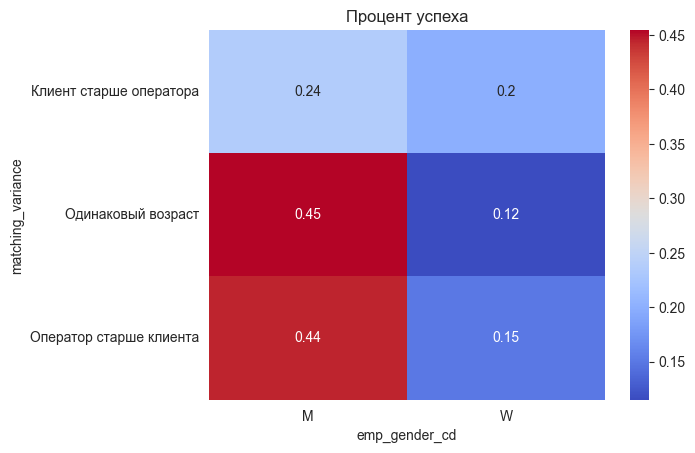

In [48]:
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['MVNO'])].copy()
pivot = cc.pivot_table(index='matching_variance' , columns='emp_gender_cd', values='flag', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()
tukey = pairwise_tukeyhsd(endog=cc['flag'], groups=cc['matching_variance'], alpha=0.05)
print(tukey)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
         group1                  group2         meandiff p-adj  lower  upper  reject
------------------------------------------------------------------------------------
Клиент старше операторa      Одинаковый возраст   0.0447    0.0 0.0248 0.0647   True
Клиент старше операторa Оператор старше клиента   0.0694    0.0 0.0484 0.0904   True
     Одинаковый возраст Оператор старше клиента   0.0246 0.0238 0.0026 0.0467   True
------------------------------------------------------------------------------------


In [25]:
import scipy.stats as st
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()
st.f_oneway(cc[cc.matching_variance=='Одинаковый возраст']["flag"], cc[cc.matching_variance=='Клиент старше операторa']["flag"], cc[cc.matching_variance=='Оператор старше клиента']["flag"])

F_onewayResult(statistic=np.float64(32.43206941800407), pvalue=np.float64(9.505438501334564e-15))

In [26]:
import scipy.stats as st

# Проверяем нормальность для каждой группы
for group in cc['matching_variance'].unique():
    stat, p = st.shapiro(cc[cc['matching_variance'] == group]['flag'])
    print(f"Группа {group}: статистика={stat}, p-value={p}")
    if p < 0.05:
        print("Предположение о нормальности отвергается.")
    else:
        print("Данные распределены нормально.")


Группа Оператор старше клиента: статистика=0.41453613631187314, p-value=4.064853932006599e-62
Предположение о нормальности отвергается.
Группа Одинаковый возраст: статистика=0.37439319137423366, p-value=5.1985047617932474e-67
Предположение о нормальности отвергается.
Группа Клиент старше операторa: статистика=0.2833007057368969, p-value=6.902185292923437e-75
Предположение о нормальности отвергается.


In [28]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()
now = cc[cc['auto_flg'] == 0].copy()

# Создание таблицы сопряженности для G-теста
contingency_table = pd.crosstab(
    index=[now['matching_variance'], now['emp_gender_cd']],  # Группы: matching_variance и emp_gender_cd
    columns=now['flag']  # Успешность звонка
)



# Проведение G-теста
chi2, p_value, dof, expected = chi2_contingency(contingency_table, lambda_="log-likelihood")

print("G-test (Likelihood Ratio Test) Results:")
print(f"Chi-squared statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Гипотеза о влиянии группы 'Оператор старше клиента' и W на успешность звонка подтверждается (статистически значимая зависимость).")
else:
    print("Гипотеза о влиянии группы 'Оператор старше клиента' и W на успешность звонка не подтверждается.")

G-test (Likelihood Ratio Test) Results:
Chi-squared statistic: 59.162455325818776
Degrees of freedom: 5
P-value: 1.8103166257029266e-11
Гипотеза о влиянии группы 'Оператор старше клиента' и W на успешность звонка подтверждается (статистически значимая зависимость).


In [72]:
from scipy.stats import fisher_exact
import pandas as pd

cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()

# Подготовка таблицы: успешные/неуспешные звонки в вашей группе и остальных
table = pd.crosstab(
    index=(cc['matching_variance'] == 'Оператор старше клиента') & (cc['emp_gender_cd'] == 'W'),
    columns=cc['flag']
)

# Точный тест Фишера и расчет отношения шансов
oddsratio, p = fisher_exact(table)
print(f"Отношение шансов: {oddsratio}, p-value: {p}")


Отношение шансов: 1.5588330912009427, p-value: 1.5196928509323602e-07


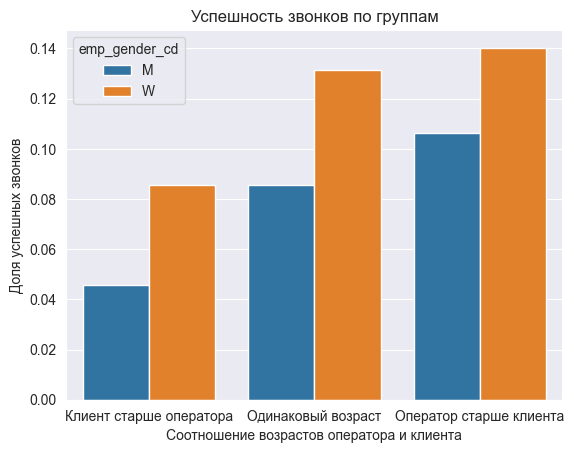

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()
# Группировка данных
success_rate = cc.groupby(['matching_variance', 'emp_gender_cd'])['flag'].mean().reset_index()

# График
sns.barplot(data=success_rate, x='matching_variance', y='flag', hue='emp_gender_cd')
plt.title("Успешность звонков по группам")
plt.ylabel("Доля успешных звонков")
plt.xlabel("Соотношение возрастов оператора и клиента")
plt.show()


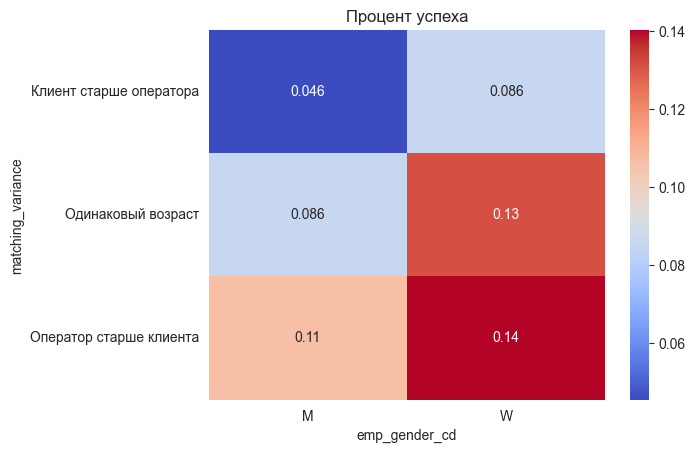

In [5]:
def sha_budet_rok(x):
    if x <= 22:
        return '18-22'
    elif x <= 30:
        return '23-30'
    elif x <= 45:
        return '31-45'
    elif x <= 60:
        return '46-60'
    elif x <= 80:
        return '61-80'
    else:
        return '80-100'

def liza_prosto_zaputalas_v_oboznacheniyah(x):
    if x == 1:
        return 'Гендеры совпадают'
    if x == 0:
        return 'Гендеры разные'

df_plus_emp['age_groups_cd'] = df_plus_emp['age'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_groups_emp'] = df_plus_emp['emp_age_new'].apply(lambda x: sha_budet_rok(x))

# Функция для получения нижней границы группы
def extract_min_age(group):
    return int(group.split('-')[0])

# Преобразуем группы в числовые значения (нижняя граница)
df_plus_emp['emp_group_min'] = df_plus_emp['age_groups_emp'].apply(extract_min_age)
df_plus_emp['client_group_min'] = df_plus_emp['age_groups_cd'].apply(extract_min_age)

df_plus_emp['matching_variance'] = np.where(df_plus_emp['emp_group_min'] > df_plus_emp['client_group_min'], 'Оператор старше клиента',
                                   np.where(df_plus_emp['emp_group_min'] == df_plus_emp['client_group_min'], 'Одинаковый возраст', 'Клиент старше операторa'))

# Удаляем временные столбцы, если они не нужны
df_plus_emp.drop(['emp_group_min', 'client_group_min'], axis=1, inplace=True)

cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()
pivot = cc.pivot_table(index='matching_variance' , columns='emp_gender_cd', values='flag', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

In [6]:
# Таблица частот для всех комбинаций matching_variance и emp_gender_cd
table = pd.crosstab(index=[cc['matching_variance'], cc['emp_gender_cd']], columns=cc['flag'])
print(table)

# Проверка процентного распределения успехов
table_success_rate = table.div(table.sum(axis=1), axis=0)  # Доля успехов
table_success_rate


flag                                      0    1
matching_variance       emp_gender_cd           
Клиент старше операторa M               586   28
                        W              1889  177
Одинаковый возраст      M               192   18
                        W              1191  180
Оператор старше клиента M               126   15
                        W              1532  250


flag                                          0         1
matching_variance       emp_gender_cd                    
Клиент старше операторa M              0.954397  0.045603
                        W              0.914327  0.085673
Одинаковый возраст      M              0.914286  0.085714
                        W              0.868709  0.131291
Оператор старше клиента M              0.893617  0.106383
                        W              0.859708  0.140292

In [7]:
# Подготовка данных для G-теста
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(table)
print(f"G-Test Chi2 statistic: {chi2}, p-value: {p}")


G-Test Chi2 statistic: 63.59033269594346, p-value: 2.1966617844188426e-12


In [9]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Создание списка групп и флага успеха
cc['group'] = cc['matching_variance'] + '_' + cc['emp_gender_cd']
watafak = cc[['group', 'flag']].dropna()
tukey = pairwise_tukeyhsd(endog=watafak['flag'], groups=watafak['group'], alpha=0.05)

print(tukey)


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
          group1                    group2          meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------------
Клиент старше операторa_M Клиент старше операторa_W   0.0401 0.0542 -0.0004 0.0806  False
Клиент старше операторa_M      Одинаковый возраст_M   0.0401 0.5825 -0.0303 0.1105  False
Клиент старше операторa_M      Одинаковый возраст_W   0.0857    0.0  0.0429 0.1285   True
Клиент старше операторa_M Оператор старше клиента_M   0.0608 0.2838 -0.0215  0.143  False
Клиент старше операторa_M Оператор старше клиента_W   0.0947    0.0  0.0535 0.1359   True
Клиент старше операторa_W      Одинаковый возраст_M      0.0    1.0 -0.0637 0.0638  False
Клиент старше операторa_W      Одинаковый возраст_W   0.0456 0.0003  0.0149 0.0763   True
Клиент старше операторa_W Оператор старше клиента_M   0.0207 0.9725 -0.0559 0.0974  False
Клиент ста

In [11]:

def matching_heatmap(df_plus_emp):
    pivot = df_plus_emp.pivot_table(values='flag', index='matching_variance', columns='emp_gender_cd', aggfunc='mean')
    sns.heatmap(pivot, annot=True, cmap='coolwarm')
    plt.title('Процент успеха')
    plt.show()

Хи-квадрат статистика: 13.08687867833186
p-value: 0.00029737144392210285
Гипотеза подтверждена: низкий доход влияет на успешность апселла

Результаты теста Тьюки:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     0      1   0.0533 0.0002 0.0248 0.0818   True
--------------------------------------------------



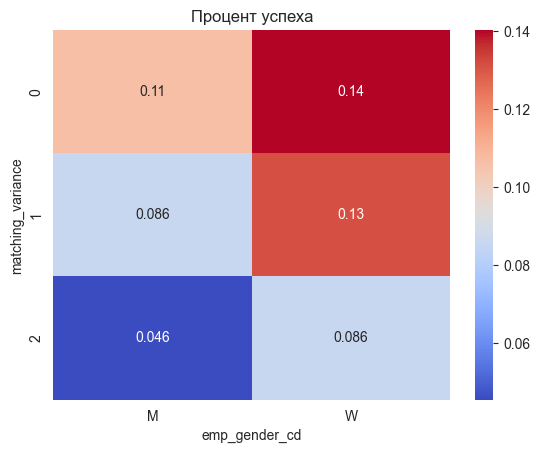

Хи-квадрат статистика: 0.8715124372087394
p-value: 0.3228258488055524
Гипотеза не подтверждена: связь между доходом и успешностью отсутствует


In [19]:
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()
cc['age_plus_gender_matching'] = ((cc['matching_variance'] == 'Оператор старше клиента') & (cc['gender_matching'] == 0))

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

# Таблица сопряженности: low_income_flg и flag (успех)
contingency_table = pd.crosstab(cc['age_plus_gender_matching'], cc['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")
    
# Пост-хок анализ Тьюки
data_long = cc.explode('flag')
tukey = pairwise_tukeyhsd(endog=data_long['age_plus_gender_matching'], groups=data_long['flag'], alpha=0.05)

print("\nРезультаты теста Тьюки:")
print(tukey)

# Преобразуем группы в числовые значения (нижняя граница)
cc['emp_group_min'] = cc['age_groups_emp'].apply(extract_min_age)
cc['client_group_min'] = cc['age_groups_cd'].apply(extract_min_age)

cc['matching_variance'] = np.where(cc['emp_group_min'] > cc['client_group_min'], 0,
                                   np.where(cc['emp_group_min'] == cc['client_group_min'], 1, 2))

# Удаляем временные столбцы, если они не нужны
cc.drop(['emp_group_min', 'client_group_min'], axis=1, inplace=True)

cc['age_plus_gender_matching'] = cc['matching_variance']*2 + cc['gender_matching']
print()

matching_heatmap(cc)

from scipy.stats import fisher_exact
# cc['age_plus_gender_matching'] = ((cc['matching_variance'] == 'Оператор старше клиента') & (cc['gender_matching'] == 0))
# Создание таблицы сопряженности
contingency_table = pd.crosstab(cc[cc['age_plus_gender_matching'].isin([4, 5])]['age_plus_gender_matching'], 
                                cc[cc['age_plus_gender_matching'].isin([4, 5])]['flag'])

# Тест хи-квадрат
# chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p = fisher_exact(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")


In [15]:
cc

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching,pol_sovpadenie,matching_variance,age_plus_gender_matching
0,23,342879157,27.0,M,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,23-30,46-60,0,Гендеры разные,0,0
1,58,141070875,34.0,M,urban,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,31-45,46-60,0,Гендеры разные,0,0
2,63,282407696,41.0,M,rural,0.0,1.0,1.0,0.0,1.0,...,0,1,0,0,31-45,46-60,1,Гендеры разные,0,0
3,94,412878747,26.0,M,urban,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,23-30,23-30,1,Гендеры разные,1,2
7,114,306996870,23.0,M,town,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,23-30,46-60,0,Гендеры разные,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14159,18077,584331549,NaN,M,town,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,80-100,18-22,0,Гендеры совпадают,2,5
14160,18110,525669032,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,80-100,31-45,0,Гендеры совпадают,2,5
14162,18220,539821879,NaN,NaN,msk,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,80-100,23-30,0,Гендеры разные,2,4
14164,18353,476196896,NaN,NaN,urban,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,80-100,31-45,0,Гендеры разные,2,4
